# Project Description
## Objective:
To build a model to predict whether a patient will progress in CKD staging or not given the patient's past longitudinal information.

## Dataset:
features: a set of longitudinal data of different lab measurements for patients diagnosed with chronic kidney disease (CKD). 

labels: you are also given the information whether these patients progress in their CKD stage or not in the future. (true/false)

In [46]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [47]:
# First glance of the data
from collections import Counter

folder_path = 'dataset'# use your path
# all_files = glob.glob(path + "/*.csv")
feature_file = ["T_creatinine.csv", 'T_DBP.csv', 'T_demo.csv', 
                'T_glucose.csv', 'T_HGB.csv', 'T_ldl.csv', 'T_meds.csv','T_SBP.csv']

feature_file_path = [os.path.join(folder_path, x) for x in feature_file]

for file in feature_file_path:
    dataset = pd.read_csv(file)
    print("ID repeats:",Counter(dataset.id).most_common(1)[0][1], end=" ")
    try:
        print("largest time: ", max(dataset.time))
    except:
        try:
            print("largest/smallest start_day ", max(dataset.start_day),
                  min(dataset.start_day), " end_day: ", max(dataset.end_day),min(dataset.end_day))
        except:
            print()
            continue
        

ID repeats: 10 largest time:  699
ID repeats: 11 largest time:  699
ID repeats: 1 
ID repeats: 8 largest time:  699
ID repeats: 22 largest time:  1429
ID repeats: 8 largest time:  699
ID repeats: 31 largest/smallest start_day  691 -78  end_day:  698 -4
ID repeats: 8 largest time:  699


# Preprocessing

In [48]:
# define a function to load data from file_name
def load_data(file_name):
    csv_path = os.path.join(folder_path, file_name)
    return pd.read_csv(csv_path,na_values=['Unknown']) # deal with race missing value

In [49]:
# define key parameters

T_stage = load_data("T_stage.csv")
# encode the stage_progress information
cat_encoder = preprocessing.LabelEncoder()
y = cat_encoder.fit_transform(T_stage["Stage_Progress"])
# total number of samples
n_samples = len(y)
# max time considered in the model
max_time = 699
# offset known from the min value of drug start day.
offset = -78
# time step size
step_size = 70
# list of time steps
timesteps = np.arange(offset, max_time, step_size)
# number of timesteps for each patient.
n_steps = len(timesteps)
print("number of time steps: ", n_steps)

neg, pos = np.bincount(T_stage['Stage_Progress'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

number of time steps:  12
Examples:
    Total: 300
    Positive: 100 (33.33% of total)



In [6]:
# Helper functions

# preprocess blood related paramters
def to_3D_array(file_name):
    # read csv file into dataset.
    dataset = pd.read_csv(file_name)
    
    # create a template dataframe with fake id 1000 with full time steps (i.e. 0:699:1)
    N_rows = max_time-offset+1 #700
    N_cols = 3
    template = pd.DataFrame(np.zeros((N_rows, N_cols)),columns = ["id", "time", 'value'])
    template.time = range(offset,max_time+1)
    template.id = [1000]*N_rows;
    
    # append the template to the current dataset.
    new_data = pd.concat([dataset,template], sort=False)
    
    # create pivot table based on the new_data.
    pivot_data = new_data.pivot(index='id', columns='time', values='value')

    # linearly intorplate the missing values row wise(ID), along time step direction.
    interpolate_pivot_data = pivot_data.interpolate(method='linear',limit_direction = "both", axis=1)

    # drop last row
    interpolate_pivot_data.drop(interpolate_pivot_data.tail(1).index,inplace=True) 

    # sampling
    sampled_data = interpolate_pivot_data.iloc[:,0:max_time-offset+1:step_size]

    threeD_data = np.reshape(sampled_data.values, (n_samples, -1, 1))
    
    return threeD_data

# preprocess deomo data: expand a numpy array function to match the size of the X matrix.
def threeD_expand(data_array):
    enlarge_array = np.repeat(data_array, n_steps, axis=0)
    # reshape to 3D array
    threeD_data = np.reshape(enlarge_array, (n_samples, n_steps, -1))
    return threeD_data



## construct X array[n_samples, n_steps, n_features]

### Part 1: Blood related parameters
Process: for each blood related parameters, 1) convert the raw data to pivot table (id vs all time steps). 2) interpolation for all missing values at different time steps. 3) sampled along time based on n_steps desired.

In [7]:
# Construct X array

# Step 1: blood related parameters
blood_features = ["T_creatinine", 'T_DBP', 
                'T_glucose', 'T_HGB', 'T_ldl','T_SBP']
feature_name = blood_features

for feature in blood_features:
    feature_path = os.path.join(folder_path, feature+'.csv')
    dataset = to_3D_array(feature_path)
    if feature == "T_creatinine":
        X = dataset
    else:
        X = np.concatenate((X,dataset),axis=2)
print(X.shape)

(300, 12, 6)


### Part 2  demographic data.
1) race: categorical data (OneHotEncoder to numeric data and imputed the unknowns with the most frequent category)

2) gender: catigorical data (LabelEncoder to numeric data)

3) age: numeric values

These values are not time-dependent, to match the size of X array, these three values were repeated "n_steps" times for each patient.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
id        300 non-null int64
race      274 non-null object
gender    300 non-null object
age       300 non-null int64
dtypes: int64(2), object(2)
memory usage: 9.5+ KB
None


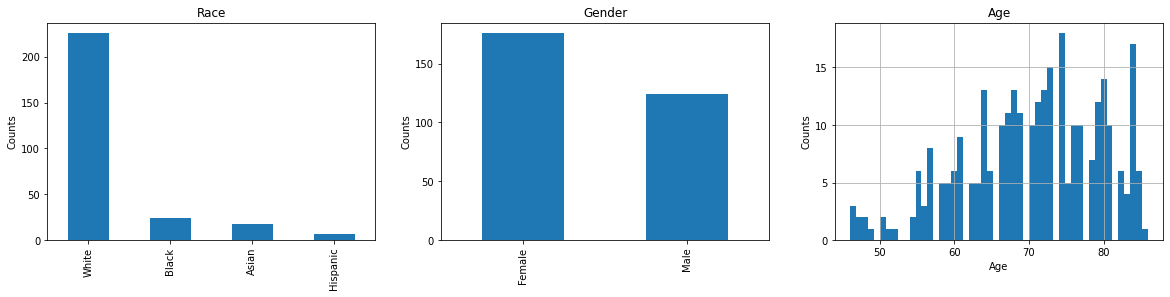

In [8]:
T_demo = load_data("T_demo.csv")
print(T_demo.info())
plt.subplot(1, 3, 1)
T_demo['race'].value_counts().plot(kind='bar',figsize=(20, 4))
# Add title and axis names
plt.title('Race')
plt.ylabel('Counts')

plt.subplot(1, 3, 2)
T_demo['gender'].value_counts().plot(kind='bar',figsize=(20, 4))
# Add title and axis names
plt.title('Gender')
plt.ylabel('Counts')

plt.subplot(1, 3, 3)
T_demo['age'].hist(bins=50,figsize=(20, 4))
# Add title and axis names
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Counts')

plt.rc('font', size=20)  


In [9]:
# fill out the missing values in race data
imp = SimpleImputer(strategy="most_frequent")
T_demo_race = pd.DataFrame(T_demo["race"], dtype="category")
T_demo_race = imp.fit_transform(T_demo_race)

# one hot encoder to encode categorical race data.
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
cat_race_1hot = onehot_encoder.fit_transform(T_demo_race)
print("Shape of encoded race data: ", cat_race_1hot.shape)
print(onehot_encoder.categories_)

# encode the gender information
cat_encoder = preprocessing.LabelEncoder()
T_demo_gender = cat_encoder.fit_transform(T_demo["gender"])
T_demo_gender = np.reshape(T_demo_gender, (-1,1))


# repeated for n_steps for each ID and match X dimension.
threeD_demo_age = threeD_expand(T_demo['age'].values)
threeD_demo_gender = threeD_expand(T_demo_gender)
threeD_demo_race = threeD_expand(cat_race_1hot)

# merge the demographic data into the X array
X = np.concatenate((X,threeD_demo_age,threeD_demo_gender,threeD_demo_race),axis=2)
print("Shape of X so far: ", X.shape)

# current feature_name
race_features = list(np.array(onehot_encoder.categories_)[0])
feature_name = feature_name + ['age', 'gender'] + race_features
print(feature_name)
                                
                                

Shape of encoded race data:  (300, 4)
[array(['Asian', 'Black', 'Hispanic', 'White'], dtype=object)]
Shape of X so far:  (300, 12, 12)
['T_creatinine', 'T_DBP', 'T_glucose', 'T_HGB', 'T_ldl', 'T_SBP', 'age', 'gender', 'Asian', 'Black', 'Hispanic', 'White']


### Part 3 Medication Data
The type of drugs were oneHotEncoded.The medicine data was added to X array for each patient by there dosage based on their start_day and end_day.

In [10]:
# medicine data
T_meds = load_data('T_meds.csv')
T_meds.info()
# encode the drug information
cat_drug = T_meds[['drug']]
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
cat_drug_1hot = onehot_encoder.fit_transform(cat_drug)
print("Shape of encoded drug data: ", cat_drug_1hot.shape)
onehot_encoder.categories_

# current feature_name
drug_features = list(np.array(onehot_encoder.categories_)[0])
feature_name = feature_name + drug_features
print(feature_name)
                         

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 5 columns):
id              2181 non-null int64
drug            2181 non-null object
daily_dosage    2181 non-null float64
start_day       2181 non-null int64
end_day         2181 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 85.3+ KB
Shape of encoded drug data:  (2181, 21)
['T_creatinine', 'T_DBP', 'T_glucose', 'T_HGB', 'T_ldl', 'T_SBP', 'age', 'gender', 'Asian', 'Black', 'Hispanic', 'White', 'atenolol', 'atorvastatin', 'bisoprolol', 'canagliflozin', 'carvedilol', 'dapagliflozin', 'irbesartan', 'labetalol', 'losartan', 'lovastatin', 'metformin', 'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin', 'pravastatin', 'propranolol', 'rosuvastatin', 'simvastatin', 'telmisartan', 'valsartan']


In [11]:
# initialization of X_meds array
X_meds = np.zeros((n_samples, max_time-offset+1, cat_drug_1hot.shape[1]))

for row in range(cat_drug_1hot.shape[0]):
    n_id = T_meds['id'].iloc[row]
    start_day = T_meds['start_day'].iloc[row]
    start_day = start_day - offset
    end_day = T_meds['end_day'].iloc[row]
    end_day = end_day - offset
    daily_dosage = T_meds['daily_dosage'].iloc[row]
    drug_index = np.where(cat_drug_1hot[row] == 1)
    # number of days on medicine
    
    n_days = end_day - start_day
    X_meds[n_id,start_day:end_day,drug_index[0]] = np.repeat(daily_dosage,n_days,axis=0)
    
# sampling of the drug data
X_meds_sampled = X_meds[:,0::step_size,:]
print("Shape of X_meds_sampled: ", X_meds_sampled.shape)

# add the meds data information in the X array
X = np.concatenate((X,X_meds_sampled),axis=2)
print("Shape of X so far: ",X.shape)

Shape of X_meds_sampled:  (300, 12, 21)
Shape of X so far:  (300, 12, 33)


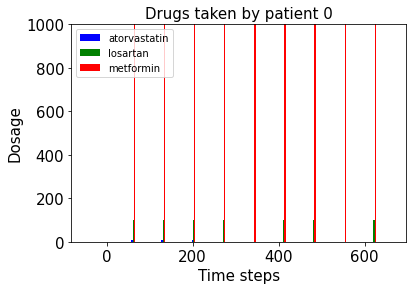

In [12]:
# visualization of one medicine usage data
x = timesteps
fg= plt.subplot(111)
w = 3
med1 = fg.bar(x-w, X_meds_sampled[0,:,1], width=w, color='b', align='center')
med2 = fg.bar(x, X_meds_sampled[0,:,8], width=w, color='g', align='center')
med3 = fg.bar(x+w, X_meds_sampled[0,:,10], width=w, color='r', align='center')
fg.autoscale(tight=True)
fg.set_xlabel("Time steps",fontsize = 15)
fg.set_ylabel("Dosage",fontsize =15)
fg.set_title('Drugs taken by patient 0', fontdict={"fontsize":15})

# fg.set_ylim((0, 15))
fg.tick_params(labelsize=15)
fg.legend((med1[0], med2[0], med3[0]), ('atorvastatin', 'losartan', 'metformin'),loc='upper left',prop=dict(size=10) )
plt.show()

## Feature importance analysis
to get a better understanding of the raw data

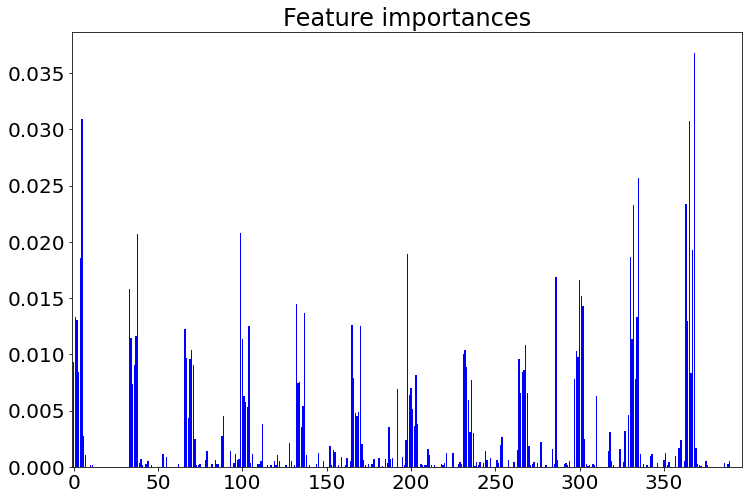

Top impotant features: 
    feature_name  importance_score
5          T_SBP          0.198497
0   T_creatinine          0.173575
2      T_glucose          0.131257
4          T_ldl          0.121699
1          T_DBP          0.119142
3          T_HGB          0.093277
22     metformin          0.029477
6            age          0.022889
13  atorvastatin          0.019511
27   pravastatin          0.013955
23    metoprolol          0.012466
32     valsartan          0.010574
30   simvastatin          0.010103
20      losartan          0.008820
21    lovastatin          0.005679


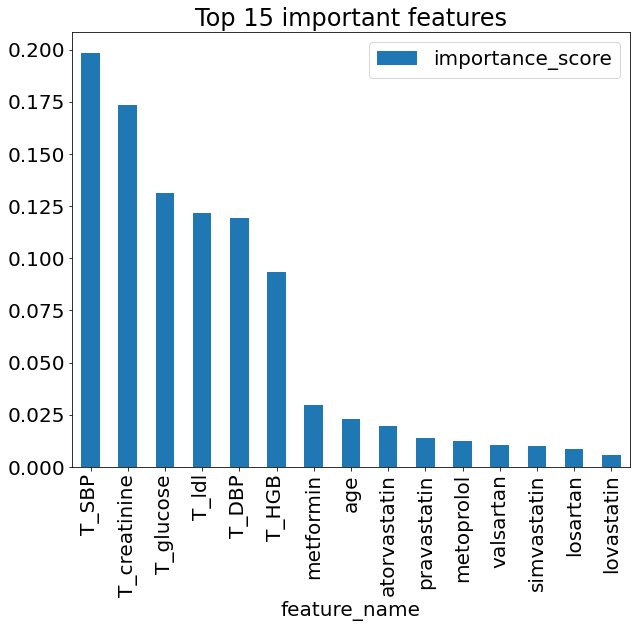

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# flatten the 3D X array to 2D for feature importance analysis
n_samples, nx, ny = X.shape
X_2d = X.reshape((n_samples,nx*ny))

# Build a forest and compute the feature importances
forest = RandomForestRegressor(n_estimators=100,
                              random_state=0)
forest.fit(X_2d, y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest for all features at all timesteps. 
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_2d.shape[1]), importances,
       color="b")
# plt.xticks(range(X_2d.shape[1]), indices)
plt.xlim([-1, X_2d.shape[1]])
plt.show()

# create a data frame to store the feature name and corresponding score.
importance_df = pd.DataFrame(np.zeros(shape=(len(feature_name),2)), columns=['feature_name', 'importance_score'])
importance_df['feature_name'] = feature_name

# the final score is the sum of individual score at different features
for f in range(nx*ny):
    importance_df.iloc[indices[f]%ny,1] = importance_df.iloc[indices[f]%ny,1] + importances[indices[f]] 
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# top_feature_df: a dataframe that stores the top 15 importance features.
top_feature_df = importance_df.nlargest(15,'importance_score')
print("Top impotant features: ")
print(top_feature_df)
top_feature_df.plot.bar(x='feature_name', y='importance_score',figsize=(10,8),title="Top 15 important features")



### Feature selection based on feature importances

In [120]:
# list of top 15 important indices

def feature_select(X):
    top_index = list(top_feature_df.index)
    print("index of top 15 important features: ",top_index)
    X_selected = X
    # loop i from 32 to 0 with step of 1, remove the row of index not in top_index
    for i in range(X.shape[2]-1,-1,-1):
        if i not in top_index:
            X_selected = np.delete(X_selected,i,axis=2)
    return X_selected

print("shape of X before feature selection: ", X.shape)
X_selected = feature_select(X)
print("shape of X before feature selection: ", X_selected.shape)

shape of X before feature selection:  (300, 12, 15)
index of top 15 important features:  [5, 0, 2, 4, 1, 3, 22, 6, 13, 27, 23, 32, 30, 20, 21]
shape of X before feature selection:  (300, 12, 15)


## Split the dataset to training and test dataset.

In [286]:
# stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    stratify=y_train, 
                                                    test_size=0.20)

print("size of X_train: ", X_train.shape)
print("size of X_val: ", X_val.shape)
print("size of X_test: ", X_test.shape)
print("y_true/y_total = {:.2f}".format(sum(y)/len(y)))
print("y_train_true/y_train_total = {:.2f}".format(sum(y_train)/len(y_train)))
print("y_val_true/y_val_total = {:.2f}".format(sum(y_val)/len(y_val)))
print("y_test_true/y_test_total = {:.2f}".format(sum(y_test)/len(y_test)))
# print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
#     total, pos, 100 * pos / total))

size of X_train:  (192, 12, 33)
size of X_val:  (48, 12, 33)
size of X_test:  (60, 12, 33)
y_true/y_total = 0.33
y_train_true/y_train_total = 0.33
y_val_true/y_val_total = 0.33
y_test_true/y_test_total = 0.33


## Feature scaling

In [287]:
# Feature scaling function
def feature_scale(X_input):
    # reshape to 2D array
    X_reshape = np.reshape(X_input,(-1,X_input.shape[2]))
    # feature scaling for each feature along all (IDs and time steps)
    scaler = preprocessing.StandardScaler()
    X_reshape_scaled = scaler.fit_transform(X_reshape)
    # recover the shape of input X
    X_scaled = np.reshape(X_reshape_scaled, X_input.shape)
    
    return X_scaled

X_train = feature_scale(X_train)
X_val = feature_scale(X_val)
X_test = feature_scale(X_test)

# Construct the Model

In [288]:
# LSTM model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# build the RNN model
output_size = 1 # 0 or 1
n_features = X_train.shape[2]
def make_model(metrics = METRICS,output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        layers.LSTM(20, activation='relu',kernel_regularizer=regularizers.l1(0.1),input_shape=(n_steps, n_features)),
#         layers.Dropout(0.5),
        layers.Dense(10,kernel_regularizer=regularizers.l1(0.1),activation='relu'),
#         layers.Dropout(0.5),
        layers.Dense(5,kernel_regularizer=regularizers.l1(0.1),activation='relu'),
        layers.Dense(output_size,activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

EPOCHS = 200
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
# summarize the model
model.summary()


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 20)                4320      
_________________________________________________________________
dense_135 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_136 (Dense)            (None, 5)                 55        
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 6         
Total params: 4,591
Trainable params: 4,591
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # check whether we need to set initial bias due to imbalanced data
# results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
# print("Loss: {:0.4f}".format(results[0]))

# initial_bias = np.log([pos/neg])
# model = make_model(output_bias = initial_bias)
# model.predict(X_train[:10])
# results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
# print("Loss: {:0.4f}".format(results[0]))

# # we don't need to set the initial bias due to similar ratio of training data.

In [289]:
# train the model
baseline_history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
#     callbacks = [early_stopping],
    validation_data=(X_val, y_val),
    verbose=0)
# save model to file
model.save('model.h5')

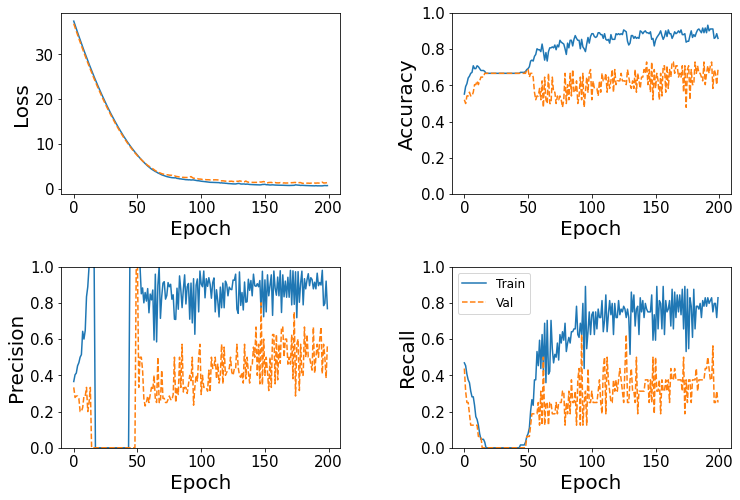

In [290]:
# Check training history
def plot_metrics(history):
    
    metrics =  ['loss', 'accuracy', 'precision', 'recall']
    fig = plt.figure(figsize=(12,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], 'C0', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 'C1', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if (n!=0):
            plt.ylim((0,1))

    plt.legend()
plot_metrics(baseline_history)


Best Threshold=0.167313


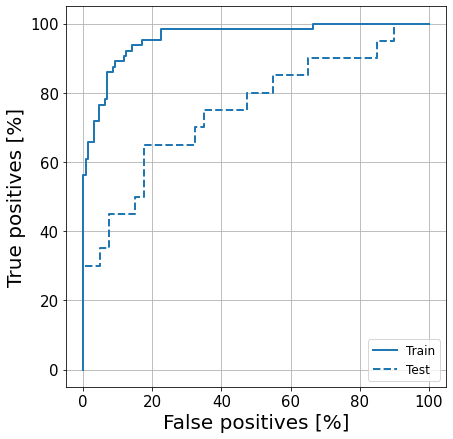

In [305]:
from sklearn.metrics import roc_curve

# make prediction
y_train_pred_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
y_test_pred_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

# choose the threshold with the largest J statistic value.
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_baseline)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

# plot the ROC curve
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]',)
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')



# calculate roc curve
# plt.figure(figsize=(7,7))
plot_roc("Train", y_train, y_train_pred_baseline, color='C0')
plot_roc("Test", y_test, y_test_pred_baseline, color='C0', linestyle='--')
plt.legend(loc='lower right')

loss :  1.1232903003692627
accuracy :  0.73333335
precision :  0.7
recall :  0.35
auc :  0.75312495

Confusion matrix of test set(upper)
Confusion matrix of training set(lower)


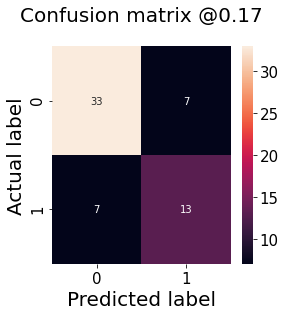

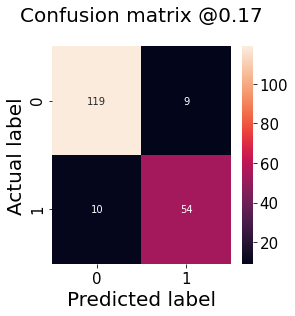

In [307]:
# Evaluation Metrics

from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_cm(labels, predictions, p=best_thresh):
    cm = confusion_matrix(labels, (predictions >= p).astype(np.int))
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

#     print('No Progression Detected (True Negatives): ', cm[0][0])
#     print('No Progression Incorrectly Detected (False Positives): ', cm[0][1])
#     print('Disease progression Missed (False Negatives): ', cm[1][0])
#     print('Disease progression Detected (True Positives): ', cm[1][1])
    
# evaluate on the testset and display the metrics
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

print("Confusion matrix of test set(upper)")
plot_cm(y_test, y_test_pred_baseline,p=best_thresh)

# evaluate on the train and display the cm
print("Confusion matrix of training set(lower)")
plot_cm(y_train, y_train_pred_baseline,p=best_thresh)

## Add Feature selection

index of top 15 important features:  [5, 0, 2, 4, 1, 3, 22, 6, 13, 27, 23, 32, 30, 20, 21]
index of top 15 important features:  [5, 0, 2, 4, 1, 3, 22, 6, 13, 27, 23, 32, 30, 20, 21]
index of top 15 important features:  [5, 0, 2, 4, 1, 3, 22, 6, 13, 27, 23, 32, 30, 20, 21]
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 20)                2880      
_________________________________________________________________
dense_156 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_157 (Dense)            (None, 5)                 55        
_________________________________________________________________
dense_158 (Dense)            (None, 1)                 6         
Total params: 3,151
Trainable params: 3,151
Non-trainable params: 0
__________________________________________

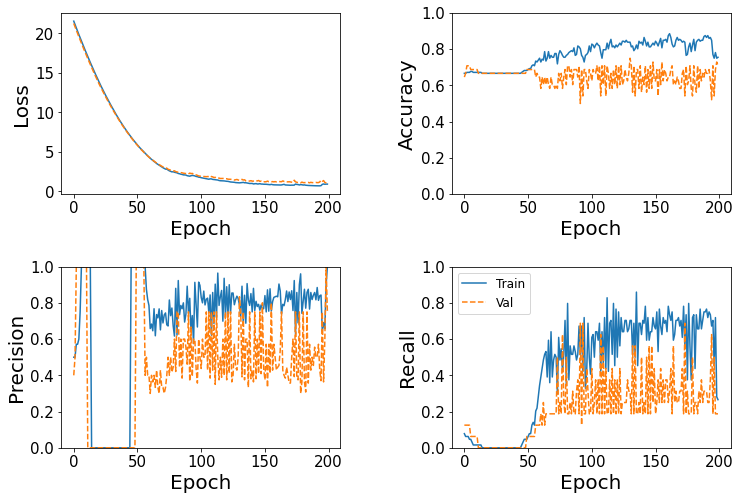

In [299]:
# add feature selection
X_train_feature = feature_select(X_train)
X_val_feature = feature_select(X_val)
X_test_feature = feature_select(X_test)


# train the same model after feature selection
n_features = X_train_feature.shape[2]
model_feature = make_model()
# summarize the model
model_feature.summary()

feature_history = model_feature.fit(
    X_train_feature, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
#     callbacks = [early_stopping],
    validation_data=(X_val_feature, y_val),
    verbose=0)

plot_metrics(feature_history)

Best Threshold=0.210007


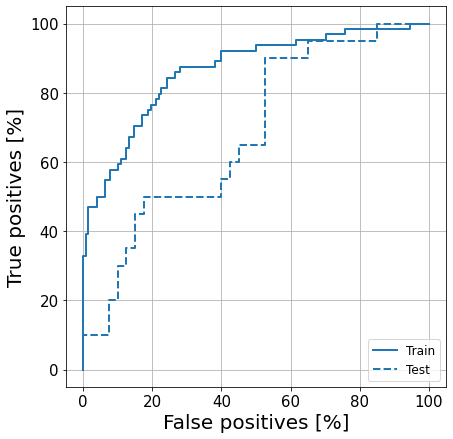

In [300]:
# make prediction and plot ROC

y_train_pred_feature = model_feature.predict(X_train_feature, batch_size=BATCH_SIZE)
y_test_pred_feature = model_feature.predict(X_test_feature, batch_size=BATCH_SIZE)

# choose the threshold with the largest J statistic value.
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_feature)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))


# calculate roc curve
# plt.figure(figsize=(7,7))
plot_roc("Train", y_train, y_train_pred_feature, color='C0')
plot_roc("Test", y_test, y_test_pred_feature, color='C0', linestyle='--')
plt.legend(loc='lower right')

loss :  0.9967650771141052
accuracy :  0.6666667
precision :  0.5
recall :  0.15
auc :  0.684375

Confusion matrix of test set(upper)


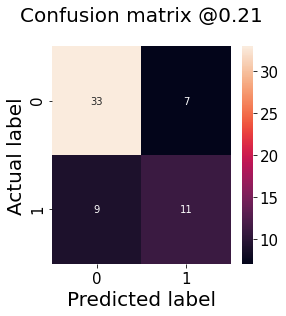

In [303]:
# evaluate on the testset and display the metrics
feature_results = model_feature.evaluate(X_test_feature, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_feature.metrics_names, feature_results):
    print(name, ': ', value)
print()

print("Confusion matrix of test set(upper)")
plot_cm(y_test, y_test_pred_baseline,p=best_thresh)
